In [ ]:
# Description: Using Long Short Term Memory (LSTM), an artificial neural network - good for sequence prediction problems, as it is able to store past information that is important and disregard the ones not.
#              to predict the closing stock price of a corporation (Nvidia)
#              using the past 120 day stock price.

In [1]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# Try fetching data with yfinance instead of pandas_datareader
!pip install yfinance #to fetch financial data
import yfinance as yf

# Get the stock quote using yfinance
df = yf.download('NVDA', start='2012-01-01', end='2024-06-24')

df

In [16]:
#get number of rows and columsn in data set
df.shape

(3137, 6)

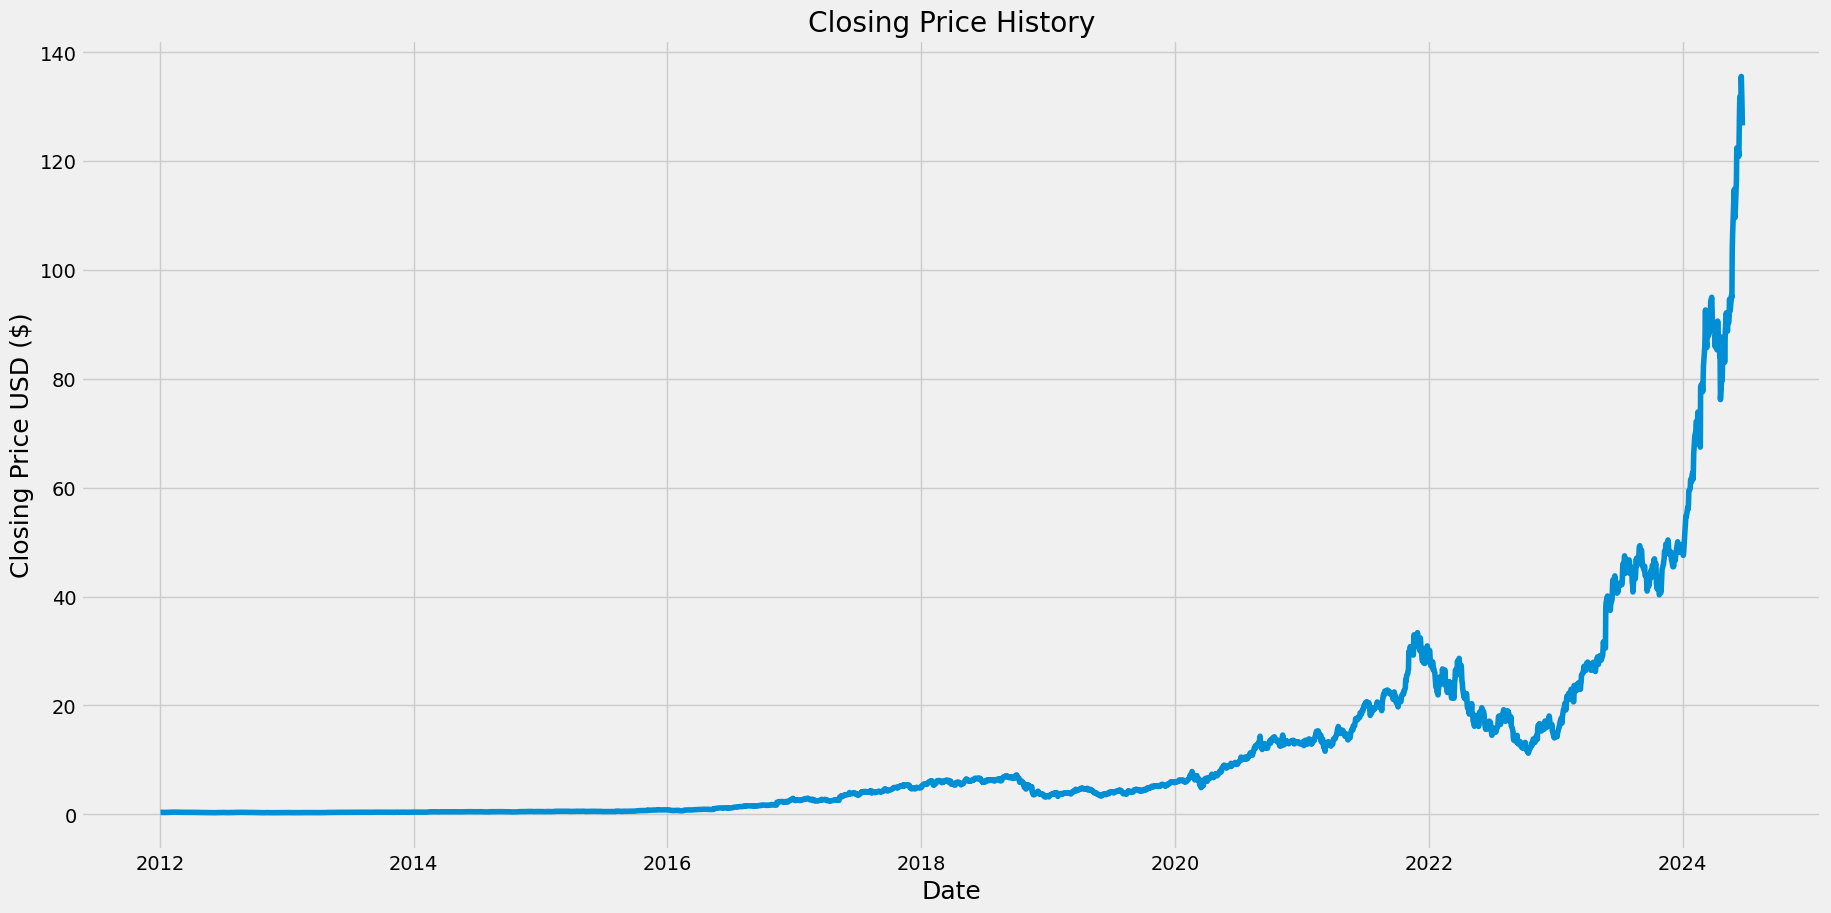

In [18]:
#visualise the closing price history
#creating plot
plt.figure(figsize=(20,10))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.show()

In [38]:
#Create new dataframe with 'Close' column
data = df.filter(['Close'])
#convert dataframe to a numpy array
dataset = data.values
#Get the number of rows to train model on
train_data_len = math.ceil(len(dataset) * .9)
train_data_len

2824

In [32]:
#Scale data - to apply preprocessing transformations and normalisation to input data before presenting to neural network.
scaler = MinMaxScaler(feature_range=(0,1)) #minMaxscaler object
scaled_data = scaler.fit_transform(dataset) #computes min and max values to be used for scaling and transforms data based on these extremes

scaled_data

array([[4.91516770e-04],
       [5.21081525e-04],
       [6.15319689e-04],
       ...,
       [1.00000000e+00],
       [9.64522080e-01],
       [9.33405013e-01]])

In [34]:
#Create a new training data set
#create scaled training data set
train_data = scaled_data[0:train_data_len, :] #array with length from 0 to training data length, ':' gets back the columns
#split data into x_train and y_train data sets
x_train = [] #initialise two arays
y_train = []

for i in  range(120, len(train_data)):
  x_train.append(train_data[i-120:i, 0]) #last 120 day values
  y_train.append(train_data[i,0]) #first 120 days
  if i<= 121:
    print(x_train) #contains first 120 days
    print(y_train) #predicts the next value
    print()

[array([4.91516770e-04, 5.21081525e-04, 6.15319689e-04, 5.83907041e-04,
       5.83907041e-04, 5.72820121e-04, 5.19233852e-04, 5.02603471e-04,
       4.34234714e-04, 3.95430712e-04, 4.80429850e-04, 5.48798606e-04,
       5.24777312e-04, 5.96841635e-04, 6.57819258e-04, 6.41189098e-04,
       6.15319689e-04, 6.52276018e-04, 6.31950070e-04, 6.26406610e-04,
       6.55971585e-04, 7.59448777e-04, 8.20426399e-04, 7.98252778e-04,
       8.05643912e-04, 9.10968997e-04, 9.09121104e-04, 8.35208887e-04,
       8.81404022e-04, 8.98034183e-04, 8.85099589e-04, 9.36838185e-04,
       8.25969860e-04, 8.40752347e-04, 8.20426399e-04, 8.37056560e-04,
       8.14882939e-04, 7.55753210e-04, 7.29883802e-04, 6.96623260e-04,
       7.15101314e-04, 7.39122829e-04, 6.43036771e-04, 6.17167583e-04,
       6.33797744e-04, 6.43036771e-04, 6.35645637e-04, 5.93146068e-04,
       6.30102177e-04, 5.52494393e-04, 5.91298175e-04, 5.94993962e-04,
       6.02385096e-04, 5.58037854e-04, 5.69124554e-04, 5.65428987e-04,
     

In [35]:
#convert x_train and y_train to numpy arays to train LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

In [39]:
#reshape x_train data set, as LSTM network expects a 3D input, num of samples, timesteps, and features (only closing in this case)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape #currently 2D


(2704, 120, 1)

In [40]:
#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25)) #25 neurons
model.add(Dense(1))

In [41]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error') #optimiser used to improve the loss function and the loss function is used to measure how well the model did on training


In [42]:
#training model
model.fit(x_train, y_train, batch_size=1, epochs=1)#epoch = num of iterations when an entire data set is passed forward and backwards through a neural network.


2704/2704 [==============================] - 152s 55ms/step - loss: 1.0062e-04


In [44]:
#create testing data set
#create a new array containg scaled values from index 2704 to 2200
test_data = scaled_data[train_data_len -120: , :]
#create the data sets x_test and y_test
x_test= []
y_test = dataset[train_data_len:, :] #actual test values

for i in range(120, len(test_data)):
  x_test.append(test_data[i -120:i, 0])

In [45]:
#Convert test data into  numpy array
x_test = np.array(x_test)

In [46]:
#Reshape data to be 3D for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [47]:
#Get the models predicted price values
predictions = model.predict(x_test)
#inverse transform data
predictions = scaler.inverse_transform(predictions) #unscaling values, to contain same values as y data test contains
#we want predictions to equal y_test

10/10 [==============================] - 1s 27ms/step


In [63]:
#Evaluate model, get Root mean squared error - standard deviation of residuals. Lower = better
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse
# 0  means perfect prediction

6.087308858145045

<ipython-input-64-96ee192bab0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


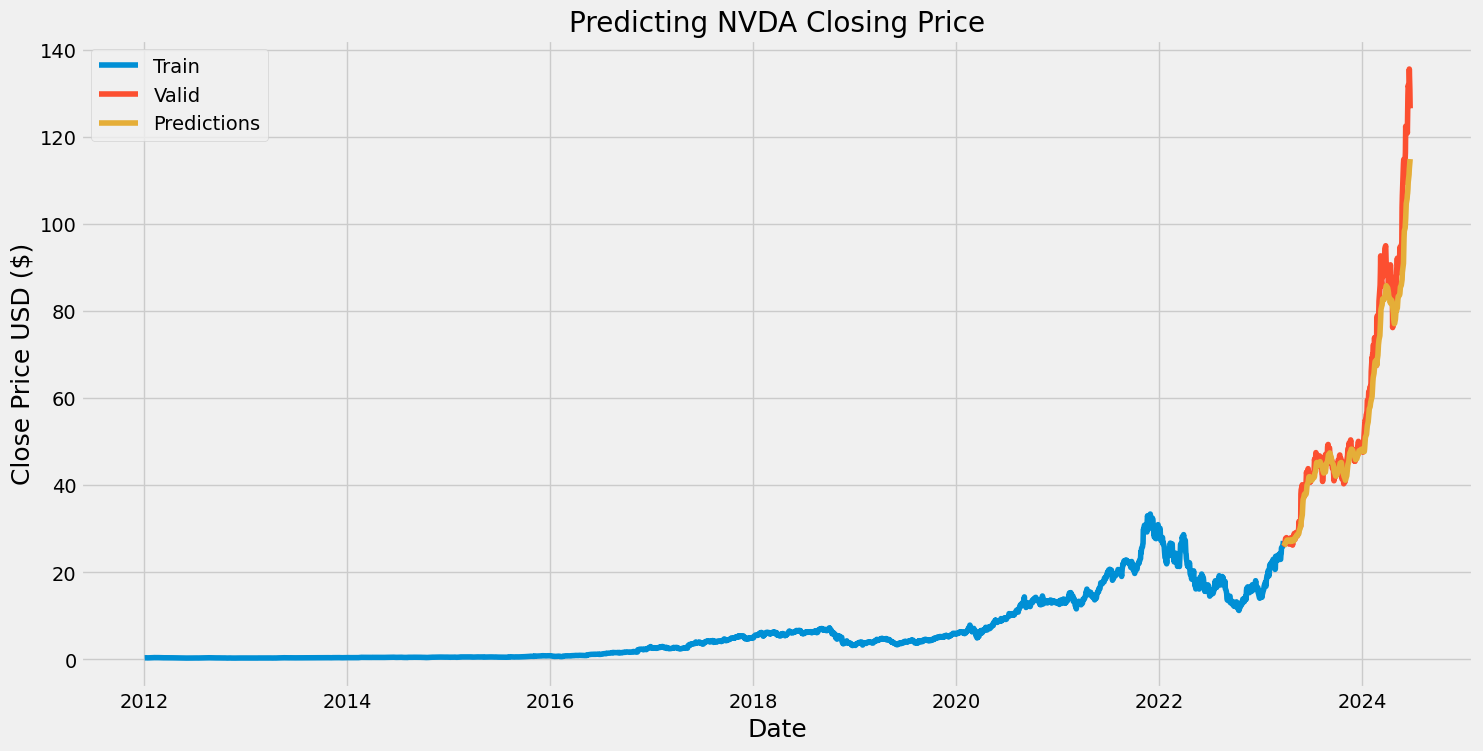

In [64]:
#plot data
train = data[0:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
#Visualise model
plt.figure(figsize=(16,8))
plt.title('Predicting NVDA Closing Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close']) #give data
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')
plt.show()

In [65]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-03-24,26.778999,26.028797
2023-03-27,26.531000,26.300686
2023-03-28,26.410000,26.453798
2023-03-29,26.983999,26.518539
2023-03-30,27.382999,26.623041
...,...,...
2024-06-14,131.880005,109.572578
2024-06-17,130.979996,111.314629
2024-06-18,135.580002,112.640663


In [66]:
#Getting predicted price for June 25th 2024

#get the quote
# Get the stock quote using yfinance
nvidia_quote = yf.download('NVDA', start='2012-01-01', end='2024-06-25')

#create new dataframe
new_df = nvidia_quote.filter(['Close'])
#get the last 120 day closing price values and convert dataframe to an array
last_120_days = new_df[-120:].values
#scale the data to be values between 0 and 1
last_120_days_scaled = scaler.transform(last_120_days)
#create empty list
X_test = []
#Append past 120 days to list
X_test.append(last_120_days_scaled)
#convert the X_test data set to a numpy array to use in LSTM model
X_test = np.array(X_test)
#reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price) #Predicted price for June 24th 2024

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 30ms/step
[[112.5567]]


In [67]:
#Getting actual closing price on date

#get quote
nvidia_quote2 = yf.download('NVDA', start='2024-06-25', end='2024-06-25')
print(nvidia_quote2['Close'])

[*********************100%%**********************]  1 of 1 completed

Date
2024-06-24    118.110001
Name: Close, dtype: float64
